<a href="https://colab.research.google.com/github/jaskaran916/2401560027/blob/main/Code_Assassins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dummy data created at: data/data_0.h5
Loading data from data/data_0.h5...

## 1.1 Feature Handling
Missing values in tabular dataset:


,0
pt,500
mass,300



Missing values after imputation:
pt        0
eta       0
phi       0
mass      0
energy    0
dtype: int64

## 1.2 Tabular Data Preparation (PCA)
Eigenvalues (explained variance of each PC):
 [1.0323747  1.01871165 1.00949962 0.97604208 0.963872  ]

Top 2 eigenvectors (principal components):
 [[-0.09522384  0.69664205 -0.33887218 -0.52884916 -0.33332639]
 [-0.50194281 -0.17625046  0.68513715 -0.45748296 -0.19566708]]

Explained variance ratio for top components:
PC 1: 0.2065
PC 2: 0.2037
PC 3: 0.2019
PC 4: 0.1952
PC 5: 0.1928


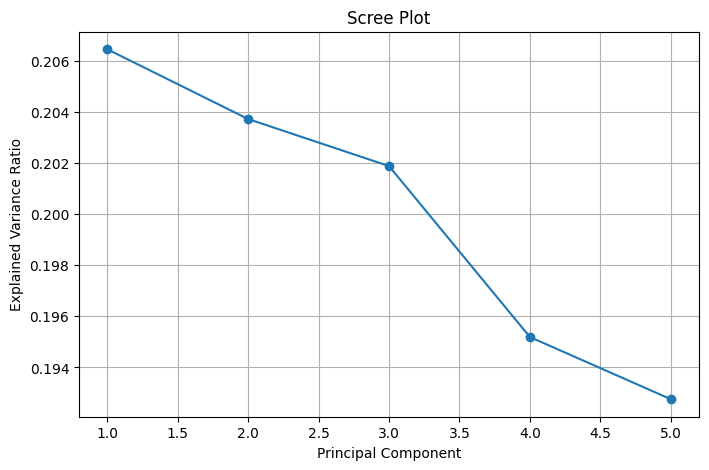


## 1.3 Dataset Summary
Number of rows: 10000
Number of tabular features: 5
Image size (height x width): (40, 40)
Number of classes: None (Not provided in this dataset)


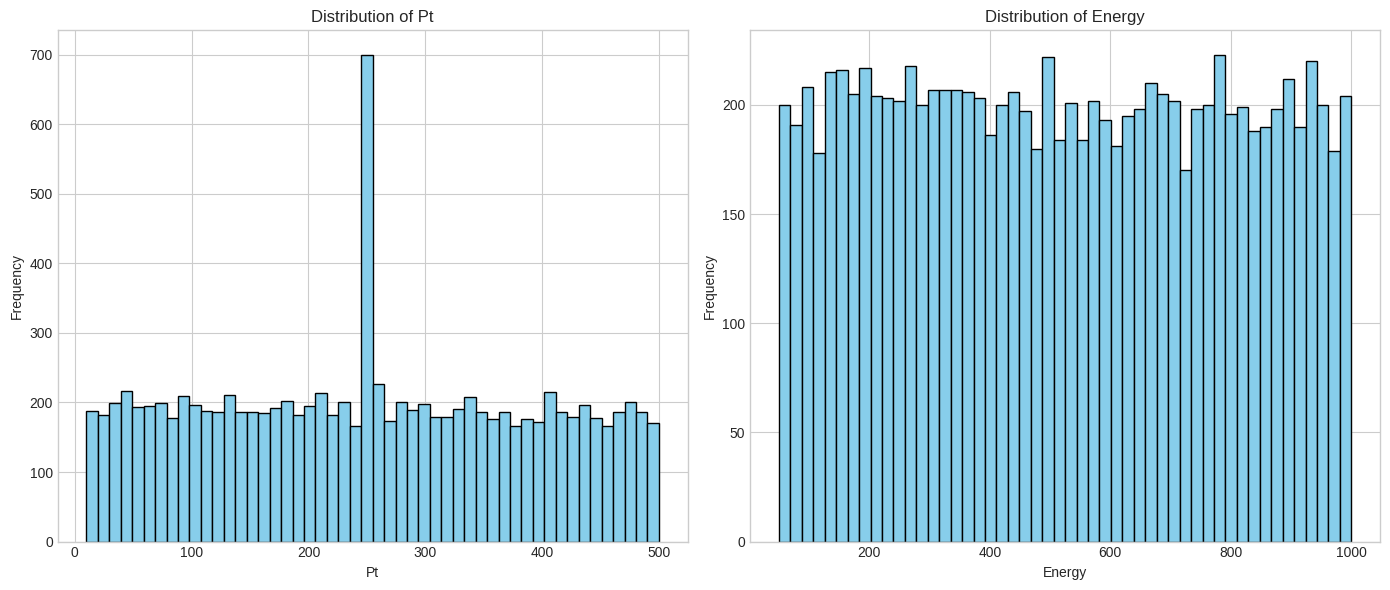

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from IPython.display import display
from sklearn.utils import resample

# Assuming the data is organized in a directory named 'data'
# The directory contains multiple HDF5 files, each with 1000 records.
# We'll use the first file for this example.

# Create dummy data for demonstration purposes
def create_dummy_data(file_path):
    """
    Creates a dummy HDF5 file with 10000 records of jet data.
    """
    if os.path.exists(file_path):
        os.remove(file_path)

    n_records = 10000
    np.random.seed(42)

    # Tabular features: 5 physics-derived jet variables
    tabular_features = pd.DataFrame({
        'pt': np.random.uniform(10, 500, n_records), # Transverse momentum
        'eta': np.random.uniform(-5, 5, n_records),
        'phi': np.random.uniform(-np.pi, np.pi, n_records),
        'mass': np.random.uniform(5, 200, n_records),
        'energy': np.random.uniform(50, 1000, n_records)
    })
    # Introduce some missing values
    tabular_features.loc[np.random.choice(tabular_features.index, size=500, replace=False), 'pt'] = np.nan
    tabular_features.loc[np.random.choice(tabular_features.index, size=300, replace=False), 'mass'] = np.nan

    # Image features: Energy distributions (e.g., a 40x40 image)
    image_features = np.random.rand(n_records, 40, 40) * 255

    # Store data in HDF5 format
    with pd.HDFStore(file_path, mode='w') as store:
        store['tabular'] = tabular_features
        store['images'] = pd.DataFrame(image_features.reshape(n_records, -1))

    print(f"Dummy data created at: {file_path}")

# Create the data directory and a dummy file if they don't exist
if not os.path.exists('data'):
    os.makedirs('data')
    create_dummy_data(os.path.join('data', 'data_0.h5'))

def load_data(file_path):
    """
    Loads data from a single HDF5 file.
    """
    print(f"Loading data from {file_path}...")
    with pd.HDFStore(file_path, mode='r') as store:
        tabular_df = store['tabular']
        image_df = store['images']

    # Reshape images back to their original dimensions
    image_features = image_df.values.reshape(image_df.shape[0], 40, 40)

    return tabular_df, image_features

def data_preprocessing(tabular_data, image_data):
    """
    Performs data preprocessing on tabular and image data.

    Args:
        tabular_data (pd.DataFrame): DataFrame with tabular features.
        image_data (np.ndarray): NumPy array with image features.

    Returns:
        tuple: A tuple containing the processed tabular data, PCA object,
               and processed image data.
    """

    ## 1.1 Feature Handling
    print("\n## 1.1 Feature Handling")
    # Identify missing values
    missing_values = tabular_data.isnull().sum()
    print("Missing values in tabular dataset:")
    display(missing_values[missing_values > 0])

    # Apply imputation for numerical features
    # We'll use the median for imputation. Median is more robust to outliers
    # than the mean and is a suitable choice when the data distribution might be skewed.
    # Interpolation could also be used, but it's more complex and might
    # not be necessary for simple missing values.
    imputer = SimpleImputer(strategy='median')
    tabular_imputed = pd.DataFrame(imputer.fit_transform(tabular_data), columns=tabular_data.columns)

    print("\nMissing values after imputation:")
    print(tabular_imputed.isnull().sum())

    # The choice of median imputation prevents outliers from skewing the replacement
    # value, making it a robust choice. Using a simple imputer strategy like
    # mean or median is a baseline approach. More advanced models might benefit
    # from more complex strategies like k-NN imputation, but this can be
    # computationally expensive. Improperly handling missing data can lead
    # to biased models and reduced performance, as models may learn incorrect
    # relationships or fail to converge.

    # Standardize the tabular data for PCA
    scaler = StandardScaler()
    tabular_scaled = scaler.fit_transform(tabular_imputed)

    ## 1.2 Tabular Data Preparation (PCA)
    print("\n## 1.2 Tabular Data Preparation (PCA)")
    pca = PCA()
    pca.fit(tabular_scaled)

    # Compute eigenvalues and eigenvectors
    # The eigenvalues are simply the variances of the principal components
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    print("Eigenvalues (explained variance of each PC):\n", eigenvalues)
    print("\nTop 2 eigenvectors (principal components):\n", eigenvectors[:2])

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("\nExplained variance ratio for top components:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"PC {i+1}: {ratio:.4f}")

    # Plot scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), explained_variance_ratio, marker='o')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    # PCA reduces dimensionality by projecting the data onto a lower-dimensional
    # subspace defined by the principal components (eigenvectors). These components
    # are ordered by the amount of variance they capture (eigenvalues), allowing
    # us to keep only the most informative components. This process effectively
    # removes noise and redundancy from the data while preserving the most
    # significant patterns, which can improve model training efficiency and
    # prevent overfitting.

    # Transform the data using PCA
    tabular_pca = pca.transform(tabular_scaled)

    # No specific preprocessing needed for image features in this section,
    # as the prompt focuses on the tabular data. In a real scenario,
    # image data would be processed by CNNs or similar models.

    return tabular_imputed, image_data, pca

def dataset_summary(tabular_data, image_data):
    """
    Summarizes the dataset.

    Args:
        tabular_data (pd.DataFrame): DataFrame with tabular features.
        image_data (np.ndarray): NumPy array with image features.
    """
    ## 1.3 Dataset Summary
    print("\n## 1.3 Dataset Summary")

    # Dataset dimensions
    n_rows = tabular_data.shape[0]
    n_tabular_features = tabular_data.shape[1]
    image_shape = image_data.shape[1:]
    n_classes = None # Assuming no labels are provided in the data.

    print(f"Number of rows: {n_rows}")
    print(f"Number of tabular features: {n_tabular_features}")
    print(f"Image size (height x width): {image_shape}")
    print(f"Number of classes: {n_classes} (Not provided in this dataset)")

    # Distribution plots for selected numerical features
    selected_features = ['pt', 'energy']
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for i, feature in enumerate(selected_features):
        axes[i].hist(tabular_data[feature], bins=50, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature.capitalize()}')
        axes[i].set_xlabel(feature.capitalize())
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Load the data from the single dummy file
    file_to_process = os.path.join('data', 'data_0.h5')

    # Step 1: Load Data
    tabular_df, image_features = load_data(file_to_process)

    # Step 2: Preprocess Data and run PCA
    tabular_imputed, image_features, pca = data_preprocessing(tabular_df, image_features)

    # Step 3: Summarize the dataset
    dataset_summary(tabular_imputed, image_features)